In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt


In [3]:
!conda install -y gdown

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.8.0             |     pyhd8ed1ab_0          13 KB  conda-forge
    gdown-4.5.3                |     pyhd8ed1ab_0          17 KB  conda-forge
    openssl-1.1.1s             |       h166bdaf_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.8.0-pyhd8ed1ab_0 None
  gdown              conda-forge/noarch::gdown-4.5.3-pyhd8ed1ab_0 None

The following packages will be UPDATED:

  openssl                                 1.1.1q-h166bdaf_0 --> 1.1.1s-h166bdaf_0 None



openssl-1.1.1s       | 2.1 MB    | ##########

In [4]:
import gdown

url = 'https://drive.google.com/file/d/1KY1eqXDMu4zPgT8B6Vx7MkJCYWsTNRRk'

output = 'file.zip'

gdown.download(url, output, quiet=False)

/opt/conda/lib/python3.7/site-packages/gdown/parse_url.py:39: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  url="https://drive.google.com/uc?id={}".format(file_id)
Downloading...
From: https://drive.google.com/file/d/1KY1eqXDMu4zPgT8B6Vx7MkJCYWsTNRRk
To: /kaggle/working/file.zip
70.9kB [00:00, 33.0MB/s]


'file.zip'

In [5]:
!gdown --id 1KY1eqXDMu4zPgT8B6Vx7MkJCYWsTNRRk

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KY1eqXDMu4zPgT8B6Vx7MkJCYWsTNRRk
To: /kaggle/working/CNN_assignment.zip
100%|█████████████████████████████████████████| 824M/824M [00:08<00:00, 100MB/s]


In [6]:
import os
os.listdir()

['file.zip',
 '__notebook_source__.ipynb',
 'CNN_assignment.zip',
 '.virtual_documents']

In [7]:
#extracting zip file
import zipfile
z= zipfile.ZipFile('CNN_assignment.zip')
z.extractall()

In [8]:
train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [9]:
image_count_train = len(list(train.glob('*/*.jpg')))
print('Images in training dataset: ',image_count_train)
image_count_test = len(list(test.glob('*/*.jpg')))
print('Images in testing dataset: ',image_count_test)

Images in training dataset:  2239
Images in testing dataset:  118


In [10]:
batch_size = 32
img_height = 180
img_width = 180

### Creating train and validation dataset

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
            train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2022-11-16 11:18:00.315867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:18:00.316876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:18:00.759916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:18:00.760805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:18:00.761559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
            train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing one instance of all the nine classes present in the dataset

In [14]:
for images, labels in train_ds:
    unique_li = []
    unique_images = []
    for i in range(32):
        if class_names[labels[i]] not in unique_li:
            unique_li.append(class_names[labels[i]])
            unique_images.append((class_names[labels[i]],images[i]))

2022-11-16 11:18:07.399226: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [15]:
unique_li

['basal cell carcinoma',
 'nevus',
 'vascular lesion',
 'dermatofibroma',
 'melanoma',
 'actinic keratosis',
 'pigmented benign keratosis',
 'squamous cell carcinoma',
 'seborrheic keratosis']

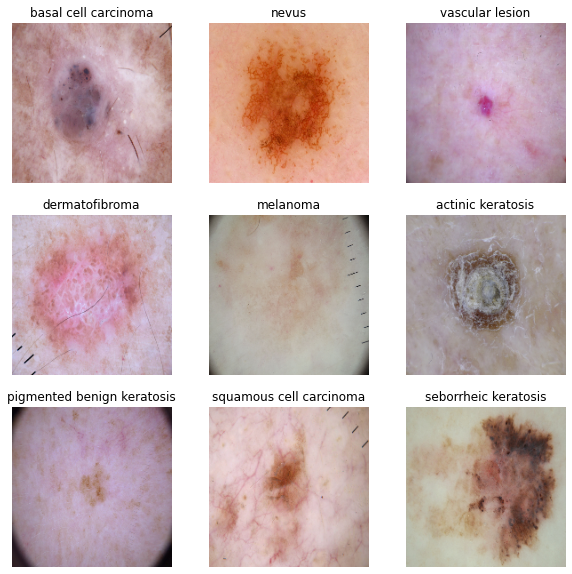

In [16]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(unique_images[i][1].numpy().astype("uint8"))
    plt.title(unique_images[i][0])
    plt.axis("off")

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1 - using dropout

In [18]:
num_class = 9
img_size = 180
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.Resizing(img_size, img_size),# Resizing the image to 180x180
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_class,activation='softmax')
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2022-11-16 11:18:29.318179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 45 of 1000
2022-11-16 11:18:29.788350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-11-16 11:18:31.607921: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


56/56 [==============================] - 29s 79ms/step - loss: 2.1022 - accuracy: 0.2204 - val_loss: 2.0626 - val_accuracy: 0.2349
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7581 - accuracy: 0.3806 - val_loss: 1.6434 - val_accuracy: 0.4273
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6273 - accuracy: 0.4157 - val_loss: 1.6315 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4708 - accuracy: 0.4738 - val_loss: 1.5236 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3987 - accuracy: 0.5106 - val_loss: 1.4312 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3533 - accuracy: 0.5229 - val_loss: 1.5118 - val_accuracy: 0.4832
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3634 - accuracy: 0.5140 - val_loss: 1.3274 - val_accuracy: 0.5503
Epoch 8/20
56/56 [=====

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
resizing (Resizing)          (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0

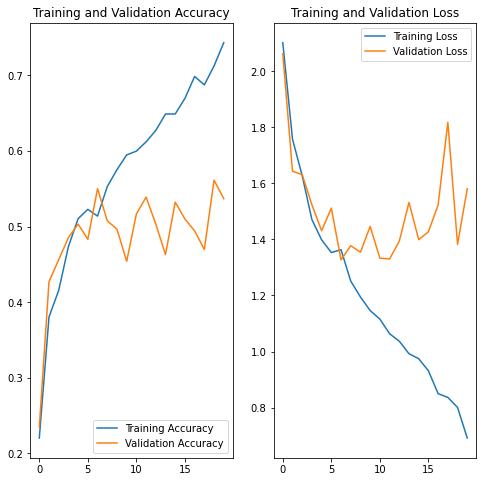

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
accuracy_results_df = pd.DataFrame(data=[{"Type":"Model1 using Dropout","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_results_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Model1 using Dropout,0.743304,0.536913,20


**Observations on model1 :**
- The training accuracy at the end we got is 70% and validation accuracy is 52%. Since there is huge gap between training and validation accuracy, the model will not perform well on newer dataset.
- As we can see from the plot that as the number of epochs increases, the training accuracy also increased but the validation accuracy reduced. This is clear case of overfitting.
- We can also see that training loss decreased and validation loss increased with the number of epochs.

### Data augmentation

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.2)
])

(-0.5, 179.5, 179.5, -0.5)

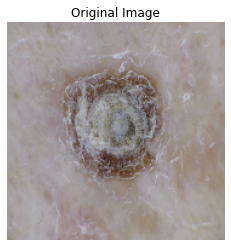

In [26]:
import random
image = tf.expand_dims(unique_images[random.randint(0,9)][1], 0)
plt.imshow(image[0].numpy().astype("uint8"))
plt.title("Original Image")
plt.axis("off")

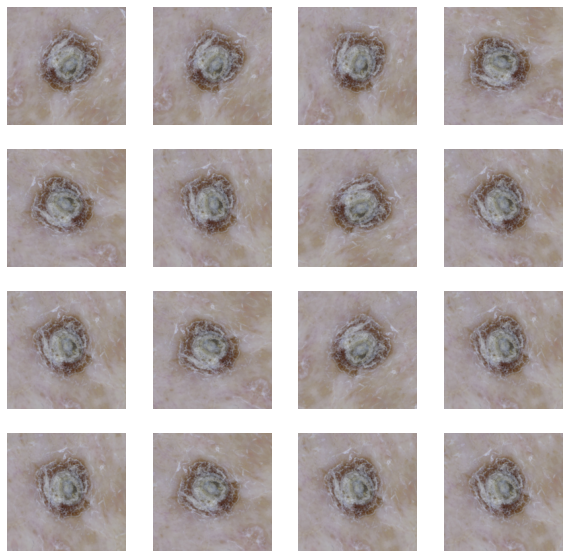

In [27]:
augmented_image = data_augmentation(image)
plt.figure(figsize=(10, 10))
for i in range(16):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

- We can see that slight rotations are applied to the images using the data augmentation


In [28]:
num_class = 9
img_size = 180
model_data = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.Resizing(img_size, img_size),# Resizing the image to 180x180
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_class,activation='softmax')
])

In [29]:
model_data.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              )
model_data.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)       

In [30]:
epochs = 20
# Lets the fit the model with batch size of 32 and 20 epochs
history_data = model_data.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 3s 30ms/step - loss: 2.1700 - accuracy: 0.2277 - val_loss: 1.9456 - val_accuracy: 0.2819
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.7126 - accuracy: 0.3683 - val_loss: 1.7954 - val_accuracy: 0.3177
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6513 - accuracy: 0.3968 - val_loss: 1.6469 - val_accuracy: 0.4452
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5334 - accuracy: 0.4604 - val_loss: 1.5386 - val_accuracy: 0.4810
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5176 - accuracy: 0.4648 - val_loss: 1.5890 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4930 - accuracy: 0.4732 - val_loss: 1.5154 - val_accuracy: 0.4810
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4442 - accuracy: 0.4905 - val_loss: 1.5422 - val_accuracy: 0.4966
Epoch 8/20
56/56 [======

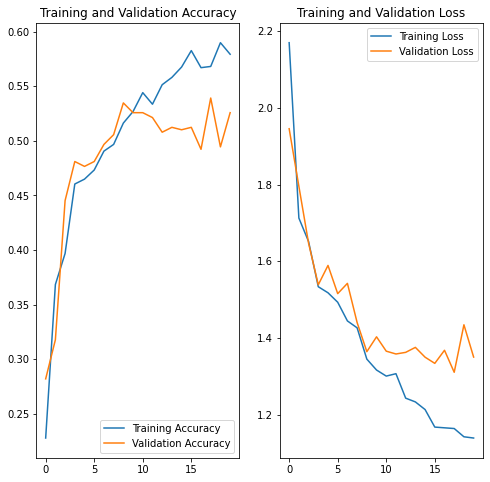

In [31]:
acc = history_data.history['accuracy']
val_acc = history_data.history['val_accuracy']

loss = history_data.history['loss']
val_loss = history_data.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
accuracy_results_df = accuracy_results_df.append([{"Type":"Model2 using Data Augmentation","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_results_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Model1 using Dropout,0.743304,0.536913,20
0,Model2 using Data Augmentation,0.579241,0.525727,20


**Observations on model2 - Model using Data augmentaion**
- We can observe that training and validation accuracy are almost similar, hence overfitting issue has resolved.
- But we can see that accuracy is around 50% which is very low.

### Checking distribution of classes in the training dataset

In [33]:

classes_dict={}
# Go through all training dataset batches
for image_batch, labels_batch in train_ds:
  # prepare the count of images in each class
    for i in range(image_batch.shape[0]):
        if class_names[labels_batch[i]] in classes_dict:
            classes_dict[class_names[labels_batch[i]]]+=1
        else:
            classes_dict[class_names[labels_batch[i]]]=1

In [34]:
classes_dict

{'pigmented benign keratosis': 370,
 'melanoma': 352,
 'basal cell carcinoma': 309,
 'vascular lesion': 115,
 'dermatofibroma': 77,
 'nevus': 277,
 'actinic keratosis': 92,
 'squamous cell carcinoma': 142,
 'seborrheic keratosis': 58}

In [35]:
# class distribution in Dataframe
df_distr = pd.DataFrame({"Class Name":classes_dict.keys(), "Samples":classes_dict.values()})
df_distr.sort_values('Samples',ascending=False)

,Class Name,Samples
0,pigmented benign keratosis,370
1,melanoma,352
2,basal cell carcinoma,309
5,nevus,277
7,squamous cell carcinoma,142
3,vascular lesion,115
6,actinic keratosis,92
4,dermatofibroma,77
8,seborrheic keratosis,58


### Visualizing class distribution

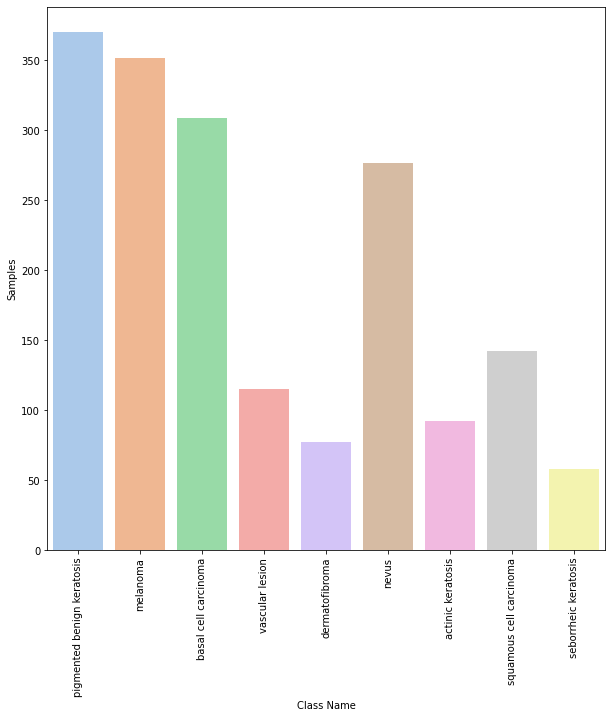

In [36]:
# Lets visualize Class Distribution
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(data=df_distr,x='Class Name',y='Samples',palette='pastel')
plt.xticks(rotation = 90) 
plt.show()

**Observations on Class Imbalance :**
- Which class has the least number of samples?
> seborrheic keratosis

- Which classes dominate the data in terms proportionate number of samples?
> pigmented benign keratosis

### Rectifying the class imbalance 

In [37]:
!pip install Augmentor

In [38]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5554343350>: 100%|██████████| 500/500 [00:17<00:00, 29.23 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F513E2D95D0>: 100%|██████████| 500/500 [00:17<00:00, 27.98 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F513EF28090>: 100%|██████████| 500/500 [00:18<00:00, 27.69 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F513E3410D0>: 100%|██████████| 500/500 [01:34<00:00,  5.30 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F513E33D750>: 100%|██████████| 500/500 [01:34<00:00,  5.29 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F513EC22290>: 100%|██████████| 500/500 [00:17<00:00, 29.20 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F513E3C7B50>: 100%|██████████| 500/500 [00:41<00:00, 11.92 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F513E3A7F90>: 100%|██████████| 500/500 [00:17<00:00, 28.11 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F513E2F3410>: 100%|██████████| 500/500 [00:17<00:00, 28.00 Samples/s]


In [39]:
image_count_train = len(list(train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
path_list = [x for x in train.glob(os.path.join('*','output', '*.jpg'))]

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in train.glob(os.path.join('*','output', '*.jpg'))]

In [42]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [43]:
df_augmentator = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df_augmentator

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
4495,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
4496,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
4497,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
4498,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma


### Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

In [45]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds_augmentor = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [46]:
val_ds_augmentor = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [47]:
num_class = 9
img_size = 180
model_augmentor_bn = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(num_class,activation='softmax')
])

In [48]:
model_augmentor_bn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              )
model_augmentor_bn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)       

In [49]:
tf.keras.backend.clear_session()

epochs = 30
# Lets the fit the model with batch size of 32 and 30 epochs
history_augmentor_bn = model_augmentor_bn.fit(
  train_ds_augmentor,
  validation_data=val_ds_augmentor,
  epochs=epochs,
  batch_size=32
)

Epoch 1/30


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


169/169 [==============================] - 26s 144ms/step - loss: 1.7041 - accuracy: 0.3789 - val_loss: 2.6055 - val_accuracy: 0.2034
Epoch 2/30
169/169 [==============================] - 26s 148ms/step - loss: 1.4832 - accuracy: 0.4471 - val_loss: 2.0972 - val_accuracy: 0.2747
Epoch 3/30
169/169 [==============================] - 25s 146ms/step - loss: 1.3986 - accuracy: 0.4757 - val_loss: 1.9622 - val_accuracy: 0.2910
Epoch 4/30
169/169 [==============================] - 26s 147ms/step - loss: 1.3592 - accuracy: 0.4911 - val_loss: 1.6961 - val_accuracy: 0.3764
Epoch 5/30
169/169 [==============================] - 25s 146ms/step - loss: 1.3264 - accuracy: 0.4961 - val_loss: 1.8619 - val_accuracy: 0.3088
Epoch 6/30
169/169 [==============================] - 25s 145ms/step - loss: 1.2894 - accuracy: 0.5147 - val_loss: 1.8690 - val_accuracy: 0.3482
Epoch 7/30
169/169 [==============================] - 25s 141ms/step - loss: 1.2761 - accuracy: 0.5171 - val_loss: 1.5212 - val_accuracy: 0.4

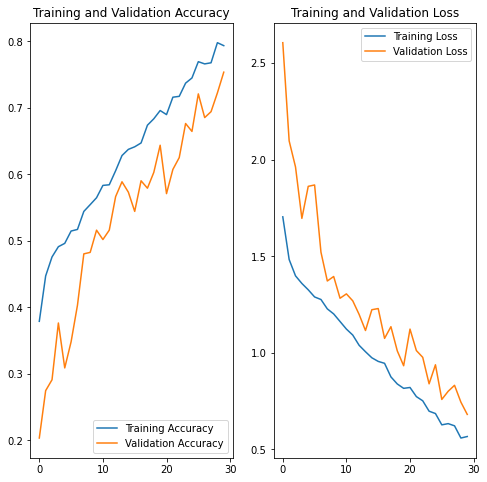

In [50]:
acc = history_augmentor_bn.history['accuracy']
val_acc = history_augmentor_bn.history['val_accuracy']

loss = history_augmentor_bn.history['loss']
val_loss = history_augmentor_bn.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
accuracy_results_df = accuracy_results_df.append([{"Type":"Model3 using Balanced data with Normalization","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_results_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Model1 using Dropout,0.743304,0.536913,20
0,Model2 using Data Augmentation,0.579241,0.525727,20
0,Model3 using Balanced data with Normalization,0.793398,0.753526,30


**Observations on model3 - Model using rectified data with Normalizationn**
- The training accuracy at the end we got is 79% and validation accuracy is 75%. We can observe a rise in accuracy without causing overfitting.
- We also observe in the graph that there are huge jerks in validation accuracy.

In [52]:
num_class = 9
img_size = 180
model_augmentor = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
#     layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
#     layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
#     layers.BatchNormalization(),
    layers.Dense(num_class,activation='softmax')
])

In [53]:
model_augmentor.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              )
model_augmentor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0

In [54]:
tf.keras.backend.clear_session()

epochs = 30
# Lets the fit the model with batch size of 32 and 20 epochs
history_augmentor = model_augmentor.fit(
  train_ds_augmentor,
  validation_data=val_ds_augmentor,
  epochs=epochs,
  batch_size=32
)

Epoch 1/30


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


169/169 [==============================] - 26s 146ms/step - loss: 2.2719 - accuracy: 0.1983 - val_loss: 1.8724 - val_accuracy: 0.2903
Epoch 2/30
169/169 [==============================] - 26s 147ms/step - loss: 1.7724 - accuracy: 0.3145 - val_loss: 1.7389 - val_accuracy: 0.3482
Epoch 3/30
169/169 [==============================] - 26s 145ms/step - loss: 1.5614 - accuracy: 0.3995 - val_loss: 1.5622 - val_accuracy: 0.4180
Epoch 4/30
169/169 [==============================] - 25s 144ms/step - loss: 1.4743 - accuracy: 0.4379 - val_loss: 1.5520 - val_accuracy: 0.4157
Epoch 5/30
169/169 [==============================] - 25s 145ms/step - loss: 1.4157 - accuracy: 0.4546 - val_loss: 1.4572 - val_accuracy: 0.4343
Epoch 6/30
169/169 [==============================] - 25s 146ms/step - loss: 1.3582 - accuracy: 0.4828 - val_loss: 1.4359 - val_accuracy: 0.4766
Epoch 7/30
169/169 [==============================] - 25s 146ms/step - loss: 1.3072 - accuracy: 0.5032 - val_loss: 1.3439 - val_accuracy: 0.4

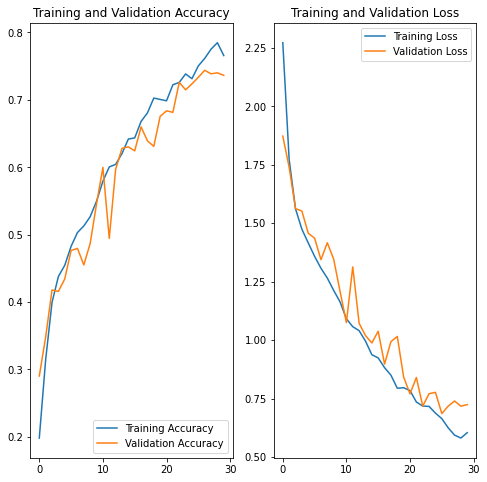

In [55]:
acc = history_augmentor.history['accuracy']
val_acc = history_augmentor.history['val_accuracy']

loss = history_augmentor.history['loss']
val_loss = history_augmentor.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
accuracy_results_df = accuracy_results_df.append([{"Type":"Model4 using Balanced data and without Normalization","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_results_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Model1 using Dropout,0.743304,0.536913,20
0,Model2 using Data Augmentation,0.579241,0.525727,20
0,Model3 using Balanced data with Normalization,0.793398,0.753526,30
0,Model4 using Balanced data and without Normali...,0.765764,0.736451,30


**Observations on model4 - Model using rectified data without Normalizationn**
- The training accuracy at the end we got is 76% and validation accuracy is 73%.
- We also observe in the graph that there are no huge jerks in validation accuracy.